### Import Libraries

The random forest model is imported from the h2o library since sklearn cannot directly handle categorical variables with multiple categories. One-hot encoding potentially loses some of the information. Refer to https://roamanalytics.com/2016/10/28/are-categorical-variables-getting-lost-in-your-random-forests/ for more details.

In [1]:
import pandas as pd
import numpy as np
import sklearn.linear_model as sklm
from sklearn.model_selection import KFold
import sklearn.metrics as skm
import sklearn.ensemble as ske
import sklearn.preprocessing as skp
from sklearn.feature_selection import VarianceThreshold
from fancyimpute import SimpleFill, KNN, MICE, SoftImpute
from imblearn.over_sampling import SMOTE
import h2o
from h2o.estimators import H2ORandomForestEstimator
from sklearn.linear_model import LinearRegression
import skmice
import matplotlib.pyplot as plt
import pdb
%matplotlib inline

C:\Users\Karthik\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


### Train logistic regression and random forest models

In [2]:
def lr_train(X_train, y_train, penalty, reg_const):
	model = sklm.LogisticRegression(penalty = penalty, C = reg_const)
	model.fit(X_train, y_train)
	return model

In [3]:
def h2o_rf_train(X_train, y_train):
	df_train = pd.concat([X_train, y_train], axis=1)
	h_train = h2o.H2OFrame(df_train)
	model = H2ORandomForestEstimator(ntrees=200, max_depth = 5, mtries = int(df_train.shape[1]/5), seed=1000000)
	model.train(X_train.columns.tolist(), 'poor', training_frame = h_train)
	return model

### Functions for model predictions

In [4]:
def sklearn_predict(model, X_test):
	pred = model.predict(X_test)
	probs = model.predict_proba(X_test)
	poor_probs = probs[:, 1]
	return pred, poor_probs

In [5]:
def h2o_rf_predict(model, X_test):
	X_test_h2o = h2o.H2OFrame(X_test)
	h_pred = model.predict(X_test_h2o)
	pred = h_pred.as_data_frame()['predict']
	poor_probs = h_pred.as_data_frame()['True']
	return pred, poor_probs

###  Evaluate the performance of the model using k-fold validation

The evaluation metrics are mean log loss (the metric in the competition) and the AUC score.

In [6]:
def model_evaluate_cv(X_train, y_train, country, penalty, reg_const, k = 5):
	# k-fold cross validation
	print("Performance on cross validation")
	log_losses = []
	auc_scores = []
	kf = KFold(n_splits = k, shuffle = True)
	for train, val in kf.split(X_train):
		X_train_kf, X_val_kf, y_train_kf, y_val_kf = X_train.iloc[train], X_train.iloc[val], y_train.iloc[train], y_train.iloc[val]
		if country == "A":
			df, mean_log_loss = model_build_country_A(X_train_kf, y_train_kf, X_val_kf, range(len(X_val_kf)), penalty, reg_const, evaluate = False)
		elif country == "B":
			df, mean_log_loss = model_build_country_B(X_train_kf, y_train_kf, X_val_kf, range(len(X_val_kf)), penalty, reg_const, evaluate = False)
		else:
			df, mean_log_loss = model_build_country_C(X_train_kf, y_train_kf, X_val_kf, range(len(X_val_kf)), penalty, reg_const, evaluate = False)
		log_loss_kf = skm.log_loss(y_true = y_val_kf, y_pred = df['poor'])
		log_losses.append(log_loss_kf)
		auc_score = get_auc_score(y_val_kf, df['poor'])
		auc_scores.append(auc_score)
	print("Mean Log loss: ", sum(log_losses)/len(log_losses))
	print("Mean AUC score: ", sum(auc_scores)/len(auc_scores))
	print("\n")
	return sum(log_losses)/len(log_losses)

### Evaluate performance on the training set

Calculate the training set performance to compare the difference in performance between training and validation. This helps evaluate if the model is underfitting or overfitting:

* If the performance in the training set is much higher than the performance on the validation set, then the model is overfitting. 
* If the performance on the training set and the validations set are both low, then the model is underfitting. 
* If the performance on the training set and the validations set are both comparable and good, then the model is neither underfitting nor overfitting.

In [7]:
def model_evaluate_training(X_train, y_train, model):
	pred_train, probs_train = sklearn_predict(model, X_train)
	# pred_train, probs_train = h2o_rf_predict(model, X_train)
	log_loss_train = skm.log_loss(y_true = y_train, y_pred = probs_train)
	auc_score_train = get_auc_score(y_train, probs_train, plot = True)
	return log_loss_train, auc_score_train

In [8]:
def get_auc_score(y, probs, plot = False):
	if plot:
		fpr, tpr, thresholds = skm.roc_curve(y_true = y, y_score = probs)
		plt.plot(fpr, tpr, 'k-o')
		plt.ylim(0,1.05)
		plt.yticks(np.arange(0,1.05,0.2))
		plt.title('ROC Curve')
		plt.xlabel('False Positive Rate')
		plt.ylabel('True Positive Rate')
		plt.show()
	auc_score = skm.roc_auc_score(y_true = y, y_score = probs)
	return auc_score

### Feature Selection using variance of the features

In [9]:
def feature_select_variance(X_train, X_test, threshold_var = 0.01):
	# feature selection
	sel = VarianceThreshold(threshold = threshold_var)
	sel.fit(X_train)
	cols = X_train.columns[sel.get_support()]
	print("Number of features selected: ", len(cols))
	X_train_sel = X_train[cols]
	X_test_sel = X_test[cols]
	return X_train_sel, X_test_sel

In [10]:
def add_missing_dummy_variable_columns(X_train, X_test_raw):
	missing_columns = set(X_train.columns) - set(X_test_raw.columns)
	df_missing = pd.DataFrame(columns = list(missing_columns), index = X_test_raw.index)
	df_missing = df_missing.fillna(0)
	X_test = pd.concat([X_test_raw, df_missing], axis = 1)
	X_test = X_test[X_train.columns]
	assert(X_test.columns.equals(X_train.columns))
	return X_test

### Missing value imputation

Drop the columns that have more than 70% of the values missing. Fill in the missing values with a simple mean or soft impute algorithm from the fancyimpute library. Using the simple mean for ease of calculation in this notebook.

In [11]:
def drop_high_missing_features(df, threshold=0.7):
	# drop columns missing over threshold
	s_missing_fraction = pd.isnull(df).sum()/df.shape[0]
	high_missing_features = s_missing_fraction[s_missing_fraction > threshold].index
	# print("Number of features removed: ", len(high_missing_features))
	df_low_miss = df.drop(high_missing_features, axis = 1)
	return df_low_miss

In [12]:
def fill_missing_values(df):
	df = drop_high_missing_features(df)
	is_missing = pd.isnull(df).sum().sum()
	if is_missing:
		arr_complete = SimpleFill().complete(df)
		df = pd.DataFrame(arr_complete, columns = df.columns)	
	return df

In [13]:
def fill_missing_values_numeric_columns(df):
	df_num = df.select_dtypes(include=[np.number])
	df_non_num = df.select_dtypes(exclude=[np.number])
	df_num_imputed = fill_missing_values(df_num)
	df_imputed = pd.concat([df_num_imputed, df_non_num], axis=1)
	return df_imputed

### Aggregate features from the individiual-level surveys to the household level

The objective of the compeition is to predict poverty at the household level. Therefore, aggregating the individual-level survey data and using it along with household-level survey data.

In [14]:
def add_ind_features(df_hh, df_ind, country):
	# distribution of categorical variables
	df_ind_obj = pd.concat([df_ind['id'], df_ind.select_dtypes(include=['object'])], axis = 1)
	df_ind_cat = pd.get_dummies(df_ind_obj)
	df_sum_by_hh_id = df_ind_cat.groupby('id').sum()
	s_num_people = df_sum_by_hh_id['country_' + country]
	df_prop = df_sum_by_hh_id.drop(['country_' + country], axis = 1, errors = 'ignore').div(df_sum_by_hh_id['country_' + country], axis=0)
	df_prop['num_people'] = s_num_people
	df_cat_feat = df_prop.reset_index()
	# mean and std dev of numeric fields
	df_ind_num = df_ind.select_dtypes(include=[np.number]).drop(['iid'], axis = 1)
	df_ind_num_imputed = fill_missing_values(df_ind_num)
	df_mean = df_ind_num_imputed.groupby('id').mean().reset_index()
	df_std = df_ind_num_imputed.groupby('id').std().reset_index()
	df_num_feat = pd.merge(df_mean, df_std, how = 'outer', on = 'id', suffixes = ['_mean', '_std'])
	# combine all features with hh features
	df_ind_feat = pd.merge(df_cat_feat, df_num_feat, how = 'outer', on = 'id')
	df_merge = pd.merge(df_hh, df_ind_feat, how = 'left', on = 'id')
	return df_merge

### Data preprocessing

Umbrella function to read the data, convert categorical variables into binary variables for logistic regression, fill missing values and perform feature selection based on variance.

In [15]:
def preprocess_data(country, dummy = True):
	print("Country %s\n" %country)
	# read datasets
	df_hh_train = pd.read_csv("data/" + country + "_hhold_train.csv")
	df_hh_test = pd.read_csv("data/" + country + "_hhold_test.csv")
	df_ind_train = pd.read_csv("data/" + country + "_indiv_train.csv")
	df_ind_test = pd.read_csv("data/" + country + "_indiv_test.csv")

	# add individual data to household data
	df_all_train = add_ind_features(df_hh_train, df_ind_train, country)
	df_all_test = add_ind_features(df_hh_test, df_ind_test, country)
	
	df_train = df_all_train.drop(['id', 'country'], axis = 1)
	df_test = df_all_test.drop(['id', 'country'], axis = 1)
	
	if dummy:
		df_train = pd.get_dummies(df_train)
		df_test = pd.get_dummies(df_test)

	X_train = df_train.drop(['poor'], axis = 1)
	y_train = df_train['poor']

	print("Number of training examples: ", X_train.shape[0])
	print("Number of features: ", X_train.shape[1])

	# add missing dummy variables in test set and fill missing values
	X_test_raw = df_test
	X_test = add_missing_dummy_variable_columns(X_train, X_test_raw)
	
	# fill missing values
	if dummy:
		X_train = fill_missing_values(X_train)
		X_test = fill_missing_values(X_test)
	else:
		# fill missing values only for numeric columns
		X_train = fill_missing_values_numeric_columns(X_train)
		X_test = fill_missing_values_numeric_columns(df_test)

	low_missing_cols = list(set(X_train.columns).intersection(set(X_test.columns)))
	X_train = X_train[low_missing_cols]
	X_test = X_test[low_missing_cols]

	# feature selection based on variance
	X_train, X_test = feature_select_variance(X_train, X_test)

	test_ids = df_hh_test['id']
	return X_train, y_train, X_test, test_ids

In [16]:
def model_evaluate(model, country, penalty, reg_const, X_train, y_train):
	log_loss_train, auc_score_train = model_evaluate_training(X_train, y_train, model)
	print("Performance on training set")
	print("Log loss: ", log_loss_train)
	print("AUC: ", auc_score_train)
	print("\n")    
	mean_log_loss = model_evaluate_cv(X_train, y_train, country, penalty, reg_const, k=5)
	return mean_log_loss

In [17]:
def model_predict(model, X_test, country, ids):
	pred, probs = sklearn_predict(model, X_test)
	# pred, probs = h2o_rf_predict(model, X_test)
	df_cols = pd.DataFrame({"id": ids, "country": country, "poor": probs})
	df = df_cols[['id', 'country', 'poor']]
	return df

### Build supervised models for the three countries to predict poor households in the test set

Since the three countries have different characteristics, having them as three different functions allows us to use different models for each of the countries. However, at this point, I use regularized logistic regression for all the three countries.

In [18]:
def model_build_country_A(X_train, y_train, X_test, test_ids, penalty, reg_const, evaluate = True):
	model = lr_train(X_train, y_train, penalty, reg_const)
	mean_log_loss = model_evaluate(model, "A", penalty, reg_const, X_train, y_train) if evaluate else None 
	df = model_predict(model, X_test, country = "A", ids = test_ids)
	return df, mean_log_loss

In [19]:
def model_build_country_B(X_train, y_train, X_test, test_ids, penalty, reg_const, evaluate = True):
	model = lr_train(X_train, y_train, penalty, reg_const)
	mean_log_loss = model_evaluate(model, "B", penalty, reg_const, X_train, y_train) if evaluate else None
	df = model_predict(model, X_test, country = "B", ids = test_ids)
	return df, mean_log_loss

In [20]:
def model_build_country_C(X_train, y_train, X_test, test_ids, penalty, reg_const, evaluate = True):
	model = lr_train(X_train, y_train, penalty, reg_const)
	mean_log_loss = model_evaluate(model, "C", penalty, reg_const, X_train, y_train) if evaluate else None
	df = model_predict(model, X_test, country = "C", ids = test_ids)
	return df, mean_log_loss

### Performance on training and cross-validation

Country A

Number of training examples:  8203
Number of features:  1134
Number of features selected:  775


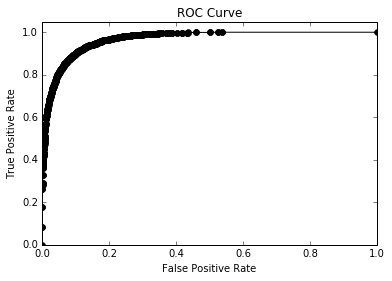

Performance on training set
Log loss:  0.231176452118
AUC:  0.967364719297


Performance on cross validation
Mean Log loss:  0.270520766889
Mean AUC score:  0.954478088383




In [21]:
# h2o.init()
X_train_a, y_train_a, X_test_a, test_ids_a = preprocess_data(country = "A", dummy = True)
df_a, log_loss_a = model_build_country_A(X_train_a, y_train_a, X_test_a, test_ids_a, penalty = "l2", reg_const = 0.1)

Country B

Number of training examples:  3255
Number of features:  3058
Number of features selected:  1518


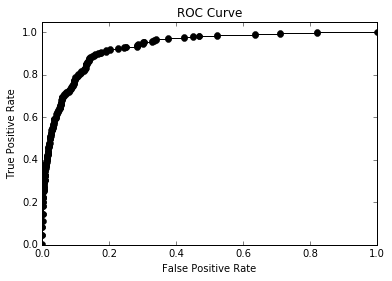

Performance on training set
Log loss:  0.160840673614
AUC:  0.931034848621


Performance on cross validation
Mean Log loss:  0.205647739457
Mean AUC score:  0.854928183826




In [22]:
X_train_b, y_train_b, X_test_b, test_ids_b = preprocess_data(country = "B", dummy = True)
df_b, log_loss_b = model_build_country_B(X_train_b, y_train_b, X_test_b, test_ids_b, penalty = "l2", reg_const = 0.01)

Country C

Number of training examples:  6469
Number of features:  1099
Number of features selected:  687


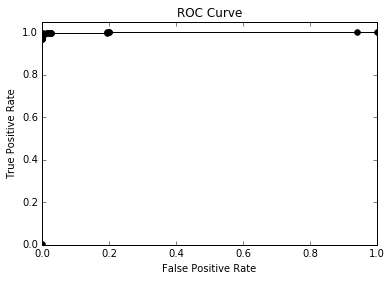

Performance on training set
Log loss:  0.0193993886694
AUC:  0.99951024832


Performance on cross validation
Mean Log loss:  0.0420742836666
Mean AUC score:  0.99819957658




In [23]:
X_train_c, y_train_c, X_test_c, test_ids_c = preprocess_data(country = "C", dummy = True)
df_c, log_loss_c = model_build_country_C(X_train_c, y_train_c, X_test_c, test_ids_c, penalty = "l1", reg_const = 1)

In [24]:
df = pd.concat([df_a, df_b, df_c], ignore_index = True)
nrows = [len(df_a), len(df_b), len(df_c)]
wts = [x/sum(nrows) for x in nrows]
wtd_log_loss = np.dot(wts, [log_loss_a, log_loss_b, log_loss_c])
print("Model Log Loss: ", wtd_log_loss)
# h2o.shutdown(prompt=False)

Model Log Loss:  0.176304816025


In [25]:
df.to_csv("output/poverty_predictions_from_notebook.csv", index = False)